In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Barley',
    'Vinterbyg': 'Barley',
    'Grønkorn af vårbyg': 'Barley',
    'Vårbyg, helsæd': 'Barley',
    'Vinterhvede': 'Wheat',
    'Vårhvede': 'Wheat',
    'Vinterhybridrug': 'Rye',
    'Vårhavre': 'Oat',
    'Silomajs': 'Maize',
    'Majs til modenhed': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Sukkerroer til fabrik': 'Sugarbeet',
    'Permanent græs, normalt udbytte': 'Grass',
    'Skovdrift, alm.': 'Forest',
    'Juletræer og pyntegrønt på landbrugsjord': 'Forest'
}

# Set seed for random generators
RANDOM_SEED = 42

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 67312, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 62131272 63199619
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 199 ms


In [3]:
ds.close()

time: 19.4 ms


In [4]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 11.5 s


In [5]:
# Dicts to hold results
test_acc_logistic_regression = {'2018-07-01': 0}
classification_reports_logistic_regression = {}
trained_classifiers_logistic_regression = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.linear_model import LogisticRegression          
    clf = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=32, max_iter=1000)
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_logistic_regression[end_date] = accuracy_test
    classification_reports_logistic_regression[end_date] = results_report 
    trained_classifiers_logistic_regression[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 9.5625 s
Prediction time: 0.0188 s

Report:

Train accuracy: 0.3795
Test accuracy: 0.3878
time: 11.6 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


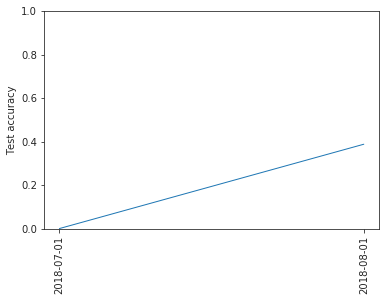

time: 148 ms


In [6]:
x = list(test_acc_logistic_regression.keys())
y = list(test_acc_logistic_regression.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

In [7]:
# Dicts to hold results
test_acc_logistic_regression_balanced = {'2018-07-01': 0}
classification_reports_logistic_regression_balanced = {}
trained_classifiers_logistic_regression_balanced = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.linear_model import LogisticRegression          
    clf = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=32, max_iter=1000, class_weight='balanced')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_logistic_regression_balanced[end_date] = accuracy_test
    classification_reports_logistic_regression_balanced[end_date] = results_report 
    trained_classifiers_logistic_regression_balanced[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 3.7775 s
Prediction time: 0.0041 s

Report:

Train accuracy: 0.2899
Test accuracy: 0.2939
time: 5.76 s


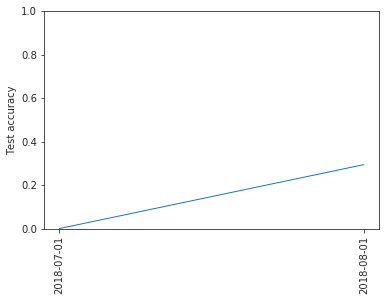

time: 131 ms


In [8]:
x = list(test_acc_logistic_regression_balanced.keys())
y = list(test_acc_logistic_regression_balanced.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [9]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 18.8 ms


In [10]:
# Dicts to hold results
test_acc_logistic_regression_cv = {'2018-07-01': 0}
classification_reports_logistic_regression_cv = {}
trained_classifiers_logistic_regression_cv = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.linear_model import LogisticRegressionCV          

    # Instantiate and evaluate classifier
    clf = LogisticRegressionCV(solver='lbfgs', multi_class='auto', cv=5, n_jobs=32, random_state=RANDOM_SEED, max_iter=1000)
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_logistic_regression_cv[end_date] = accuracy_test
    classification_reports_logistic_regression_cv[end_date] = results_report 
    trained_classifiers_logistic_regression_cv[end_date] = clf_trained 
    

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 26.0841 s
Prediction time: 0.0014 s

Report:

Train accuracy: 0.3795
Test accuracy: 0.3881
time: 28.2 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


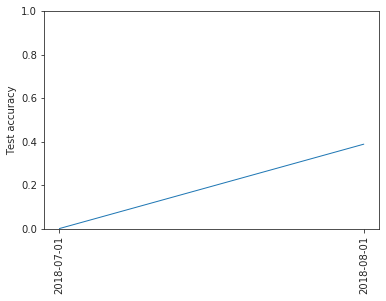

time: 111 ms


In [11]:
x = list(test_acc_logistic_regression_cv.keys())
y = list(test_acc_logistic_regression_cv.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

In [12]:
# Dicts to hold results
test_acc_logistic_regression_cv_balanced = {'2018-07-01': 0}
classification_reports_logistic_regression_cv_balanced = {}
trained_classifiers_logistic_regression_cv_balanced = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.linear_model import LogisticRegressionCV          

    # Instantiate and evaluate classifier
    clf = LogisticRegressionCV(solver='lbfgs', multi_class='auto', cv=5, n_jobs=32, random_state=RANDOM_SEED, max_iter=1000, 
                               class_weight='balanced')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_logistic_regression_cv_balanced[end_date] = accuracy_test
    classification_reports_logistic_regression_cv_balanced[end_date] = results_report 
    trained_classifiers_logistic_regression_cv_balanced[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 16.845 s
Prediction time: 0.0014 s

Report:

Train accuracy: 0.2906
Test accuracy: 0.2931
time: 18.8 s


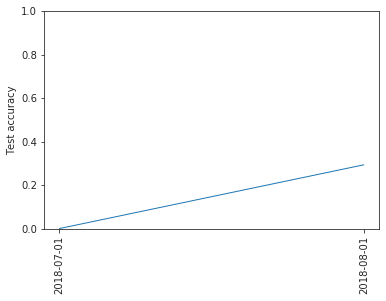

time: 117 ms


In [13]:
x = list(test_acc_logistic_regression_cv_balanced.keys())
y = list(test_acc_logistic_regression_cv_balanced.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [14]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 20 ms


In [17]:
# Dicts to hold results
test_acc_svm_linear = {'2018-07-01': 0}
classification_reports_svm_linear = {}
trained_classifiers_svm_linear = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    # Instantiate and evaluate classifier
    param_grid = {'C': [1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear']}
    #clf = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    clf = SVC(kernel='linear')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_svm_linear[end_date] = accuracy_test
    classification_reports_svm_linear[end_date] = results_report 
    trained_classifiers_svm_linear[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 90.4949 s
Prediction time: 11.3053 s

Report:

Train accuracy: 0.3557
Test accuracy: 0.3597
time: 2min 21s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


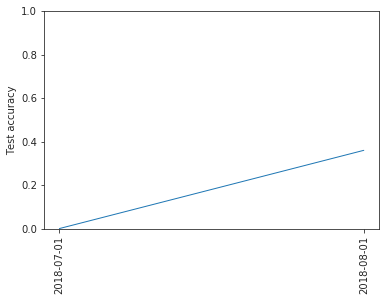

time: 127 ms


In [18]:
x = list(test_acc_svm_linear.keys())
y = list(test_acc_svm_linear.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [19]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 16.8 ms


In [20]:
# Dicts to hold results
test_acc_svm_linear_balanced = {'2018-07-01': 0}
classification_reports_svm_linear_balanced = {}
trained_classifiers_svm_linear_balanced = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    # Instantiate and evaluate classifier
    param_grid = {'C': [1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear']}
    #clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    clf = SVC(kernel='linear', class_weight='balanced')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_svm_linear_balanced[end_date] = accuracy_test
    classification_reports_svm_linear_balanced[end_date] = results_report 
    trained_classifiers_svm_linear_balanced[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 105.6457 s
Prediction time: 11.0251 s

Report:

Train accuracy: 0.2998
Test accuracy: 0.3028
time: 2min 35s


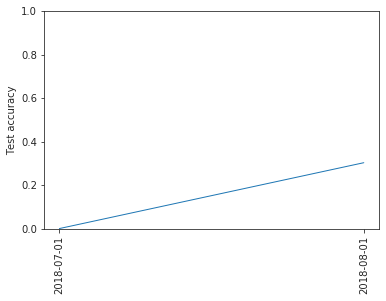

time: 128 ms


In [21]:
x = list(test_acc_svm_linear_balanced.keys())
y = list(test_acc_svm_linear_balanced.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [22]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 18.3 ms


In [23]:
# Dicts to hold results
test_acc_svm_rbf = {'2018-07-01': 0}
classification_reports_svm_rbf = {}
trained_classifiers_svm_rbf = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    # Instantiate and evaluate classifier
    param_grid = {'C': [1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['rbf']}
    #clf = GridSearchCV(SVC(), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    clf = SVC(kernel='rbf')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_svm_rbf[end_date] = accuracy_test
    classification_reports_svm_rbf[end_date] = results_report 
    trained_classifiers_svm_rbf[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 87.6069 s
Prediction time: 19.6972 s

Report:

Train accuracy: 0.427
Test accuracy: 0.424
time: 2min 54s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


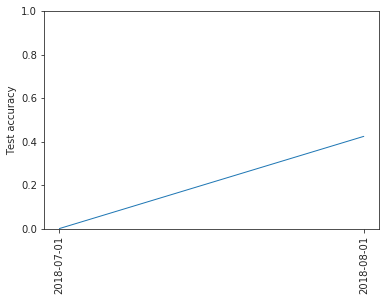

time: 112 ms


In [24]:
x = list(test_acc_svm_rbf.keys())
y = list(test_acc_svm_rbf.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [25]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)

time: 18.8 ms


In [26]:
# Dicts to hold results
test_acc_svm_rbf_balanced = {'2018-07-01': 0}
classification_reports_svm_rbf_balanced = {}
trained_classifiers_svm_rbf_balanced = {}

year = 2018
for i in range(7, 24, 1):
    month = (i % 12) + 1
    if month == 1:
        year += 1
        
    end_date = f'{year}-{month:02}-01'
        
    print(f"--------------------------------------------------------------------------------------------------")
    print(f"Dataset from 2018-07-01 to {end_date}")
    df_sklearn = get_sklearn_df(polygons_year=2019, 
                                satellite_dates=slice('2018-07-01', f'{end_date}'), 
                                fields='all', 
                                satellite='all', 
                                polarization='all',
                                crop_type='all',
                                netcdf_path=netcdf_path)

    #df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
    #                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
    
    df_sklearn_remapped = df_sklearn.copy()
    df_sklearn_remapped.insert(3, 'Crop type', '')
    df_sklearn_remapped.insert(4, 'Label ID', 0)
    mapping_dict = {}
    class_names = [] 
    i = 0
    for key, value in mapping_dict_crop_types.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
        if value not in class_names:
            class_names.append(value)
            mapping_dict[value] = i
            i += 1

    for key, value in mapping_dict.items():
        df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
    #print(f"Crop types: {class_names}")

    # Get values as numpy array
    array = df_sklearn_remapped.values

    # Define the independent variables as features.
    X = np.float32(array[:,5:])  # The features 

    # Define the target (dependent) variable as labels.
    y = np.int8(array[:,4])  # The column 'afgkode'

    # Create a train/test split using 30% test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    # Instantiate and evaluate classifier
    from sklearn.svm import SVC   
    from sklearn.model_selection import GridSearchCV

    # Instantiate and evaluate classifier
    param_grid = {'C': [1, 10, 100], 'gamma': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['rbf']}
    #clf = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, cv=5, verbose=0, n_jobs=32)
    clf = SVC(kernel='rbf', class_weight='balanced')
    clf_trained, _, accuracy_test, results_report = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names, 
                                                                        feature_scale=True, plot_confusion_matrix=False,
                                                                        print_classification_report=False)
    
    test_acc_svm_rbf_balanced[end_date] = accuracy_test
    classification_reports_svm_rbf_balanced[end_date] = results_report 
    trained_classifiers_svm_rbf_balanced[end_date] = clf_trained 

--------------------------------------------------------------------------------------------------
Dataset from 2018-07-01 to 2018-08-01
Training time: 105.2539 s
Prediction time: 18.9506 s

Report:

Train accuracy: 0.3447
Test accuracy: 0.336
time: 3min 8s


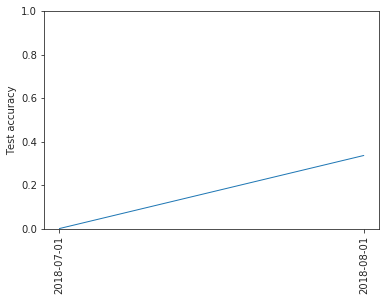

time: 133 ms


In [27]:
x = list(test_acc_svm_rbf_balanced.keys())
y = list(test_acc_svm_rbf_balanced.values())
ax = sns.lineplot(x=x, y=y, sort=False, lw=1)
ax.set_ylabel('Test accuracy')
ax.set_ylim(0, 1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
#for date, report in classification_reports_logistic_regression.items():
#    print(date)
#    print(report)